# Chapter 4: Training Models

## 📚 Assignment Summary

This notebook serves as the submission for **Chapter 4** of the book *"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow."*

**Chapter Objective:** This chapter dives deep into the *how* of model training. Until now, we've treated models like black boxes. This chapter opens them up.

We will cover:
* **Linear Regression:** How to train it using two different methods:
    1.  A direct "closed-form" equation (the **Normal Equation**).
    2.  Iterative optimization (**Gradient Descent**) and its variants (Batch, Mini-batch, and Stochastic GD).
* **Polynomial Regression:** How to use a linear model to fit non-linear data.
* **Learning Curves:** How to use them to detect if a model is overfitting or underfitting.
* **Regularization:** How to reduce overfitting by constraining the model (Ridge, Lasso, Elastic Net).
* **Logistic & Softmax Regression:** How to use these models for classification tasks.

This notebook reproduces all code from the chapter and provides theoretical explanations for each concept.

## 1. Setup

First, let's import the necessary modules and define helper functions for plotting.

In [1]:
# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2. Linear Regression

### 🧑‍🏫 Theoretical Deep-Dive: The Linear Regression Model

A linear model makes a prediction by computing a weighted sum of the input features, plus a constant called the *bias term* (or *intercept term*).

**Linear Regression model prediction:**
$$ \hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n $$

* $\hat{y}$ (y-hat) is the predicted value.
* $n$ is the number of features.
* $x_i$ is the $i^{th}$ feature value.
* $\theta_j$ is the $j^{th}$ model parameter ($	heta_0$ is the bias term, $\theta_1, \dots, \theta_n$ are the feature weights).

To train this model, we need to find the parameter values $\theta$ that minimize a cost function. The most common cost function for regression is the **Mean Squared Error (MSE)**.

### 2.1. The Normal Equation

The **Normal Equation** is a "closed-form" mathematical equation that gives the result directly—it finds the $\theta$ value that minimizes the MSE cost function.

$$ \hat{\theta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $$

Let's generate some linear-looking data and use this equation to find the best $\theta$.

Saving figure generated_data_plot


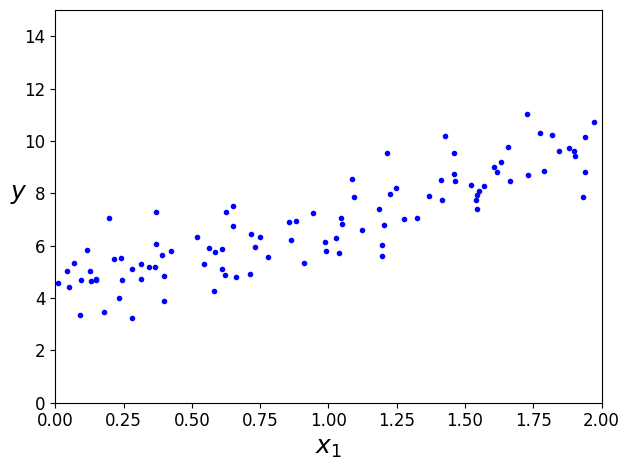

In [2]:
# Generate linear-looking data
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1) # y = 4 + 3x + Gaussian noise

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [3]:
# Compute theta_best using the Normal Equation
# We add x0 = 1 to each instance using np.c_ (this is the bias term)
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print("Best theta found by Normal Equation:")
print(theta_best)

Best theta found by Normal Equation:
[[4.21509616]
 [2.77011339]]


We were hoping for $\theta_0 = 4$ and $\theta_1 = 3$, but we got values close to that. The noise made it impossible to recover the exact parameters. Now we can make predictions using this $\hat{\theta}$.

In [4]:
# Make predictions
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
print("Predictions:")
print(y_predict)

Predictions:
[[4.21509616]
 [9.75532293]]


Saving figure linear_model_predictions_plot


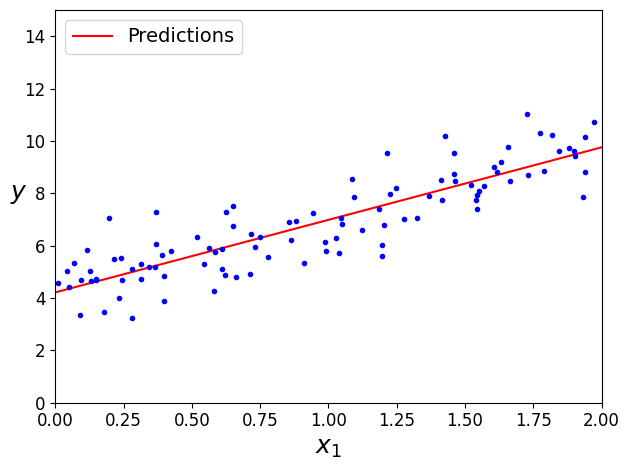

In [5]:
# Plot the model's predictions
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

### 2.2. Using Scikit-Learn

The same calculation is performed by Scikit-Learn's `LinearRegression` class.

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print("Theta (intercept and coefficient):", lin_reg.intercept_, lin_reg.coef_)
print("Predictions:", lin_reg.predict(X_new))

Theta (intercept and coefficient): [4.21509616] [[2.77011339]]
Predictions: [[4.21509616]
 [9.75532293]]


#### 🧑‍🏫 Theoretical Deep-Dive: Computational Complexity

The Normal Equation gets very slow when the number of features grows large (e.g., 100,000). The complexity is roughly $O(n^{2.4})$ to $O(n^3)$ (where *n* is the number of features). However, it is linear with regard to the number of instances ($O(m)$), so it's very fast when the dataset fits in memory, as long as there aren't too many features.

## 3. Gradient Descent

### 🧑‍🏫 Theoretical Deep-Dive: How Gradient Descent Works

**Gradient Descent (GD)** is a generic, iterative optimization algorithm capable of finding optimal solutions to a wide range of problems.

The general idea is to tweak parameters iteratively in order to minimize a cost function. It works by:
1.  Starting with random parameter values (random initialization).
2.  Measuring the local gradient of the cost function with regard to the parameters.
3.  Taking a step in the direction of the *descending* gradient (downhill).
4.  Repeating until the algorithm converges to a minimum.

A key hyperparameter is the **learning rate**, which determines the size of the steps.
* If the learning rate is **too small**, the algorithm will take a very long time to converge.
* If the learning rate is **too large**, the algorithm may jump across the valley and diverge, failing to find a good solution.

**Feature Scaling:** Gradient Descent is very sensitive to feature scales. If features have different scales, the cost function will be an elongated bowl. GD will take a long time to converge. **You must scale the data (e..g, using `StandardScaler`) before using GD.**

### 3.1. Batch Gradient Descent (Batch GD)

In Batch GD, the algorithm uses the **entire training set** to compute the gradients at every step. This makes it very slow on large datasets, but it scales well with the number of features (unlike the Normal Equation).

Here is a code reproduction of a Batch GD implementation.

In [7]:
eta = 0.1  # Learning rate
n_iterations = 1000
m = 100 # Number of instances

theta = np.random.randn(2,1)  # Random initialization

for iteration in range(n_iterations):
    # 1. Compute gradients over the full batch X_b
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)

    # 2. Take a step downhill
    theta = theta - eta * gradients

print("Best theta found by Batch GD:")
print(theta)

Best theta found by Batch GD:
[[4.21509616]
 [2.77011339]]


This is the exact same result that the Normal Equation found! The code for plotting the different learning rates is in the notebook's repository and demonstrates the effect of `eta`.

### 3.2. Stochastic Gradient Descent (SGD)

**Stochastic Gradient Descent** is the opposite of Batch GD. It picks a **single random instance** from the training set at every step and computes the gradients based only on that single instance.

* **Pro:** Much faster, as it has very little data to manipulate at each step. This allows it to train on huge datasets and be used for online learning.
* **Con:** It is much less regular ("stochastic" means random). The cost function will bounce up and down, and it will *never* settle at the minimum.

The solution to this "con" is to gradually reduce the learning rate. The function that determines the learning rate at each iteration is called the **learning schedule**.

In [8]:
n_epochs = 50
t0, t1 = 5, 50  # Learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # Random initialization

for epoch in range(n_epochs):
    for i in range(m): # Iterate m times (m instances)
        # 1. Pick a random instance
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]

        # 2. Compute gradients on that instance
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)

        # 3. Determine the learning rate
        eta = learning_schedule(epoch * m + i)

        # 4. Take the step
        theta = theta - eta * gradients

print("Best theta found by SGD:")
print(theta)

Best theta found by SGD:
[[4.18475289]
 [2.73036719]]


In [9]:
# To perform SGD with Scikit-Learn, you can use the SGDRegressor class
from sklearn.linear_model import SGDRegressor

# Note: y.ravel() is needed because SGDRegressor expects 1D targets
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

print("Theta found by SGDRegressor:")
print(sgd_reg.intercept_, sgd_reg.coef_)

Theta found by SGDRegressor:
[4.24365286] [2.8250878]


### 3.3. Mini-batch Gradient Descent

**Mini-batch GD** is a compromise. Instead of computing gradients on the full dataset or a single instance, it computes them on small random sets of instances called **mini-batches**.

**Main advantage:** It can get a significant performance boost from hardware optimization, especially with GPUs. It is less erratic than SGD but more efficient than Batch GD.

### 3.4. Comparison of Algorithms

| Algorithm | Large m | Large n | Hyperparams | Scaling required | Scikit-Learn |
| --- | --- | --- | --- | --- | --- |
| **Normal Equation** | Fast | Very Slow | 0 | No | `LinearRegression` |
| **Batch GD** | Very Slow | Fast | 2 | Yes | `SGDRegressor` |
| **Stochastic GD** | Fast | Fast | $\ge$2 | Yes | `SGDRegressor` |
| **Mini-batch GD** | Fast | Fast | $\ge$2 | Yes | `SGDRegressor` |

## 4. Polynomial Regression

We can use a linear model to fit non-linear data by adding powers of each feature as new features. This technique is called **Polynomial Regression**.

Saving figure quadratic_data_plot


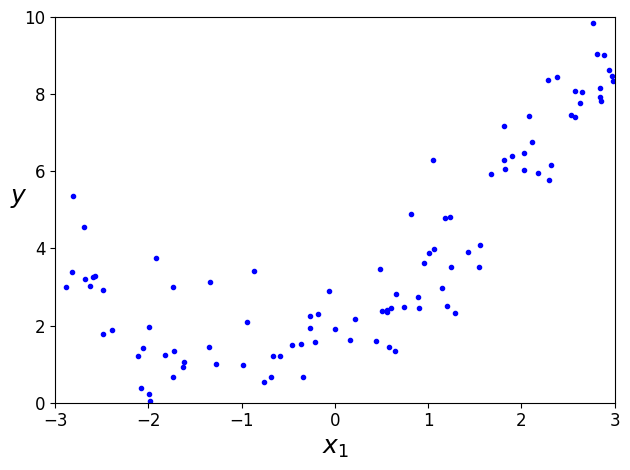

In [10]:
# Generate some non-linear (quadratic) data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [11]:
# Use Scikit-Learn's PolynomialFeatures to transform the data
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print("Original X[0]:", X[0])
print("Transformed X_poly[0]:", X_poly[0])

Original X[0]: [0.48570228]
Transformed X_poly[0]: [0.48570228 0.2359067 ]


`X_poly` now contains the original feature of `X` plus the square of this feature. Now we can fit a `LinearRegression` model to this extended data.

Theta (intercept and coefficients): [1.8699327] [[0.99763195 0.51104433]]
Saving figure polynomial_regression_plot


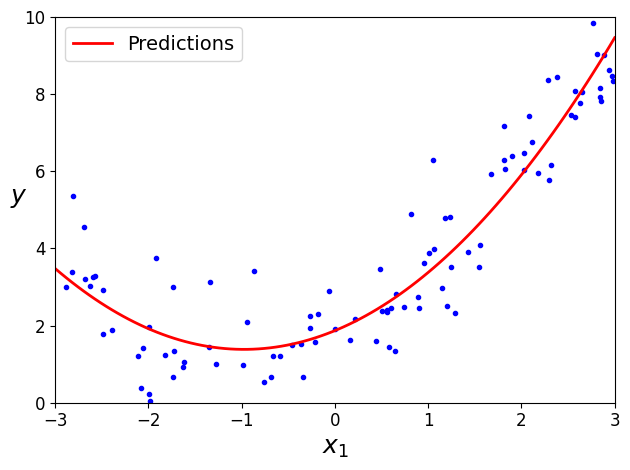

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print("Theta (intercept and coefficients):", lin_reg.intercept_, lin_reg.coef_)

# Plot the model's predictions
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("polynomial_regression_plot")
plt.show()

The model estimated $\hat{y} = 0.56x_1^2 + 0.93x_1 + 1.78$, which is very close to the original function $y = 0.5x_1^2 + 1.0x_1 + 2.0$.

## 5. Learning Curves

If we perform high-degree Polynomial Regression, we will likely overfit the data. **Learning curves** are plots of the model's performance on the training set and the validation set as a function of the training set size. They are a great tool to tell whether a model is **underfitting** or **overfitting**.

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.axis([0, 80, 0, 3])

### 5.1. Underfitting Model Example

Saving figure underfitting_learning_curves_plot


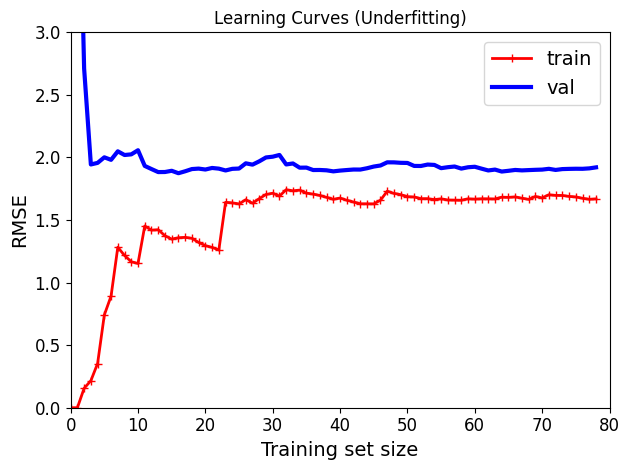

In [14]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.title("Learning Curves (Underfitting)")
save_fig("underfitting_learning_curves_plot")
plt.show()

#### 🧑‍🏫 Theoretical Deep-Dive: Reading the Underfitting Curves

These curves are typical of an **underfitting** model:
1.  **Training error:** Starts at zero (the model can perfectly fit one instance) but rises quickly and then plateaus at a high value.
2.  **Validation error:** Starts very high (it can't generalize from one instance) but decreases to meet the training error.
3.  **Conclusion:** Both curves are high and close together. This means the model is too simple and adding more training examples will *not* help.

### 5.2. Overfitting Model Example

Saving figure overfitting_learning_curves_plot


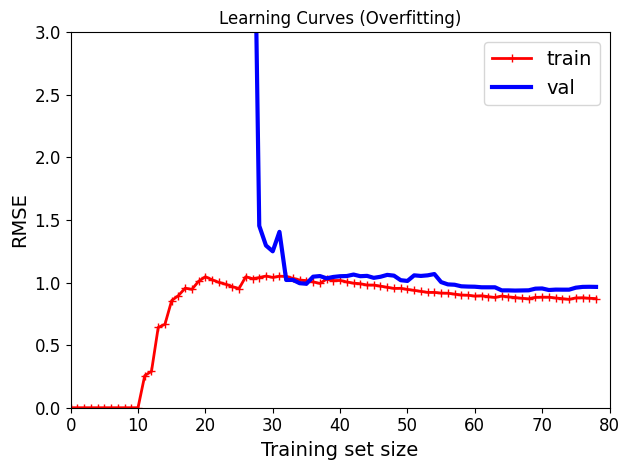

In [15]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.title("Learning Curves (Overfitting)")
plt.axis([0, 80, 0, 3])
save_fig("overfitting_learning_curves_plot")
plt.show()

#### 🧑‍🏫 Theoretical Deep-Dive: Reading the Overfitting Curves

These curves are typical of an **overfitting** model:
1.  **Training error:** The error is much lower than with the linear model.
2.  **A gap:** There is a significant gap between the training error and the validation error.
3.  **Conclusion:** The model performs much better on the training data than on the validation data. One way to improve an overfitting model is to feed it more training data, which would help the two curves converge.

### 5.3. The Bias/Variance Trade-off

A model's generalization error can be expressed as the sum of three errors:
* **Bias:** Error due to wrong assumptions (e.g., assuming data is linear when it's quadratic). A high-bias model is likely to **underfit**.
* **Variance:** Error due to excessive sensitivity to small variations in the data. A high-variance model (high flexibility) is likely to **overfit**.
* **Irreducible Error:** Error due to the noisiness of the data itself. This cannot be reduced.

Increasing a model's complexity (e.g., a higher-degree polynomial) will increase its variance and reduce its bias. Decreasing its complexity will increase its bias and reduce its variance. This is the **bias/variance trade-off**.

## 6. Regularized Linear Models

A good way to reduce overfitting is to **regularize** (constrain) the model. For linear models, this is done by constraining the model's weights.

### 6.1. Ridge Regression (Tikhonov Regularization)

**Ridge Regression** adds a regularization term to the cost function equal to $\alpha \sum_{i=1}^{n} \theta_i^2$. This is the $\ell_2$ norm.

This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. The hyperparameter $\alpha$ controls how much you regularize. If $\alpha=0$, it's just Linear Regression. If $\alpha$ is very large, all weights end up close to zero, resulting in a flat line.

**Note:** It is important to scale the data before performing Ridge Regression, as it is sensitive to the scale of the features.

In [16]:
from sklearn.linear_model import Ridge

# Example with a closed-form solution
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
print("Ridge prediction:", ridge_reg.predict([[1.5]]))

# Example with Stochastic Gradient Descent
# The 'penalty' hyperparameter sets the type of regularization term
sgd_reg = SGDRegressor(penalty="l2") # 'l2' indicates Ridge regularization
sgd_reg.fit(X, y.ravel())
print("Ridge (SGD) prediction:", sgd_reg.predict([[1.5]]))

Ridge prediction: [5.17154312]
Ridge (SGD) prediction: [5.14031966]


### 6.2. Lasso Regression

**Lasso (Least Absolute Shrinkage and Selection Operator) Regression** adds an $\ell_1$ norm regularization term: $\alpha \sum_{i=1}^{n} |\theta_i|$.

An important characteristic of Lasso is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero). This means Lasso automatically performs **feature selection** and outputs a *sparse model*.

In [17]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
print("Lasso prediction:", lasso_reg.predict([[1.5]]))

Lasso prediction: [5.13721011]


### 6.3. Elastic Net

**Elastic Net** is a middle ground between Ridge and Lasso. It's cost function is a simple mix of both Ridge and Lasso's regularization terms. The mix ratio is controlled by the $r$ hyperparameter (called `l1_ratio` in Scikit-Learn).

It is almost always preferable to have some regularization, so you should avoid plain Linear Regression. Ridge is a good default, but if you suspect only a few features are useful, Lasso or Elastic Net are better as they tend to reduce useless features' weights to zero. **Elastic Net is generally preferred over Lasso** because Lasso can behave erratically when features are strongly correlated or when there are more features than instances.

In [18]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
print("Elastic Net prediction:", elastic_net.predict([[1.5]]))

Elastic Net prediction: [5.13588066]


### 6.4. Early Stopping

**Early Stopping** is a very different way to regularize iterative learning algorithms like Gradient Descent. The idea is to simply **stop training as soon as the validation error reaches a minimum**.

As the epochs go by, the algorithm learns, and its training error (RMSE) goes down, along with its validation error. But after a while, the validation error stops decreasing and starts to go back up. This indicates that the model has started to overfit the training data. Early stopping just stops training at that minimum point.

Here is a basic implementation:

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

# 1. Prepare the data
X_train, X_val, y_train, y_val = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# 2. Create the model and set up early stopping
sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
n_epochs = 1000

# 3. Run the training loop
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)

    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

print("Best epoch:", best_epoch)
print("Minimum validation error:", minimum_val_error)

Best epoch: 644
Minimum validation error: 0.49698415169486443


## 7. Logistic Regression & Softmax Regression

Some regression algorithms can be used for classification. **Logistic Regression** (or *Logit Regression*) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., "Is this email spam?").

### 7.1. Logistic Regression (Binary Classifier)

#### 🧑‍🏫 Theoretical Deep-Dive: Estimating Probabilities

A Logistic Regression model computes a weighted sum of the inputs (like Linear Regression) but then outputs the **logistic** (also called **sigmoid**) of this result. The output is a number between 0 and 1, which can be interpreted as a probability.

The **cost function** for Logistic Regression is the **log loss**. It is a convex function, so Gradient Descent (or any other optimization algorithm) is guaranteed to find the global minimum.

In [21]:
# We will use the Iris dataset for this example
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [23]:
# Let's build a classifier to detect the Iris virginica type based only on the petal width
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(int)  # 1 if Iris virginica, else 0

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

Saving figure logistic_regression_proba_plot


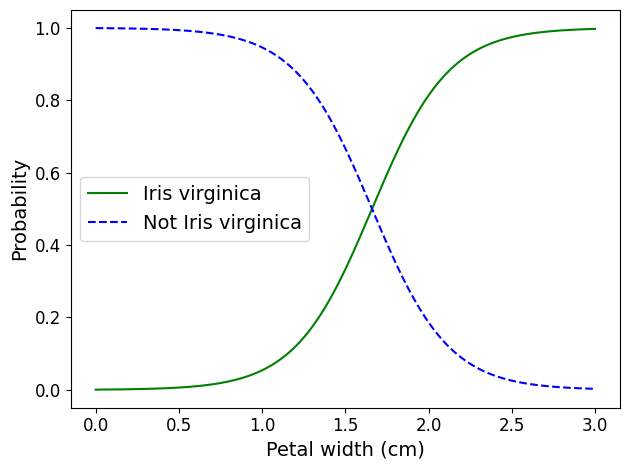

In [24]:
# Let's look at the model's estimated probabilities for flowers with petal widths from 0 to 3 cm
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
save_fig("logistic_regression_proba_plot")
plt.show()

There is a **decision boundary** around 1.6 cm. Above it, the classifier is highly confident the flower is an *Iris virginica*.

### 7.2. Softmax Regression (Multinomial Logistic Regression)

The Logistic Regression model can be generalized to support multiple classes directly. This is called **Softmax Regression**.

**How it works:**
1.  Given an instance **x**, the model first computes a score $s_k(\mathbf{x})$ for each class $k$.
2.  Then it estimates the probability of each class by applying the **softmax function** (also called the *normalized exponential*) to the scores.

The **cost function** is the **cross-entropy** (or log loss), which penalizes the model when it estimates a low probability for the target class.

Let's use it to classify the iris flowers into all three classes.

In [25]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

# To use Softmax Regression, set multi_class="multinomial"
# The solver "lbfgs" is a common solver that supports Softmax
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial')

In [26]:
# Let's predict on a flower with petal length 5cm and width 2cm
print("Prediction:", softmax_reg.predict([[5, 2]]))
print("Probabilities:", softmax_reg.predict_proba([[5, 2]]))

Prediction: [2]
Probabilities: [[6.21626374e-07 5.73689802e-02 9.42630398e-01]]


The model correctly predicts class 2 (Iris virginica) with 94.2% probability.

## Chapter 4 Conclusion

This chapter covered the most important algorithms for training linear models.

* We started with **Linear Regression** and two ways to train it: the **Normal Equation** (a direct equation) and **Gradient Descent** (an iterative optimizer).
* We explored the three flavors of GD: **Batch, Stochastic, and Mini-batch**.
* We learned how to use **Polynomial Regression** to fit non-linear data and **Learning Curves** to detect overfitting/underfitting.
* We covered four techniques to **regularize** models and reduce overfitting: **Ridge, Lasso, Elastic Net, and Early Stopping**.
* Finally, we looked at **Logistic Regression** and **Softmax Regression** for classification tasks.

We are now equipped with a solid foundation of how models actually learn, which will be essential for understanding the neural networks in Part II.